In [1]:
%pylab inline
import pymc3 as pm
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Neal (2003) defines a distribution that exemplifies the difficulties of sampling from some hierarchical models.  

## The model:

$p(y, x_n) = \text{Normal}(y \mid 0, 3) \times \displaystyle\prod_{n=1}^{9} \text{Normal}(x_n \mid 0, \text{exp}(y / 2))$

The probability contours are shaped like ten-dimensional funnels. The funnel’s neck is particularly sharp because of the exponential function applied to y. 

In [2]:
nd = 9

In [3]:
# forward random
nsample = 10000
yr = st.norm.rvs(loc=0., scale=3., size=nsample)
xnr = st.norm.rvs(loc=0., scale=np.exp(yr/2), size=(nd, nsample))

In [4]:
# compute log density
nres = 500
xval = np.linspace(-20, 20, nres)
yval = np.linspace(-9, 9, nres)
xv, yv = np.meshgrid(xval, yval)

# formally it need marginalization if nd > 1
logp_2d = st.norm.logpdf(yv, loc=0., scale=3.) +\
    st.norm.logpdf(xv, loc=0., scale=np.exp(yv/2))

In [5]:
def show_logp2d(logp_2d, ax, func = lambda x: x):
    img = ax.imshow(func(logp_2d), 
                     vmin=func(-7.5), vmax=func(-2.5), 
                     cmap='viridis', origin='lower')
    ax.grid(color='w', linestyle='-', linewidth=1, alpha=.05)
    ax.set_yticks(np.linspace(0, 499, 7))
    ax.set_yticklabels(np.linspace(-9, 9, 7).round())
    ax.set_xticks(np.linspace(0, 499, 7))
    ax.set_xticklabels(np.linspace(-20, 20, 7).round())
    ax.set_xlabel('xn[{}]'.format(ib))
    ax.set_ylabel('y')
    plt.colorbar(img, ax=ax, shrink=.5)
    return ax

def show_sample2d(xnr, yr, ib, ax):
    ax.scatter(xnr[ib], yr, marker='.', alpha=.01)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-9, 9)
    ax.set_xlabel('xn[{}]'.format(ib))
    ax.set_ylabel('y')
    return ax

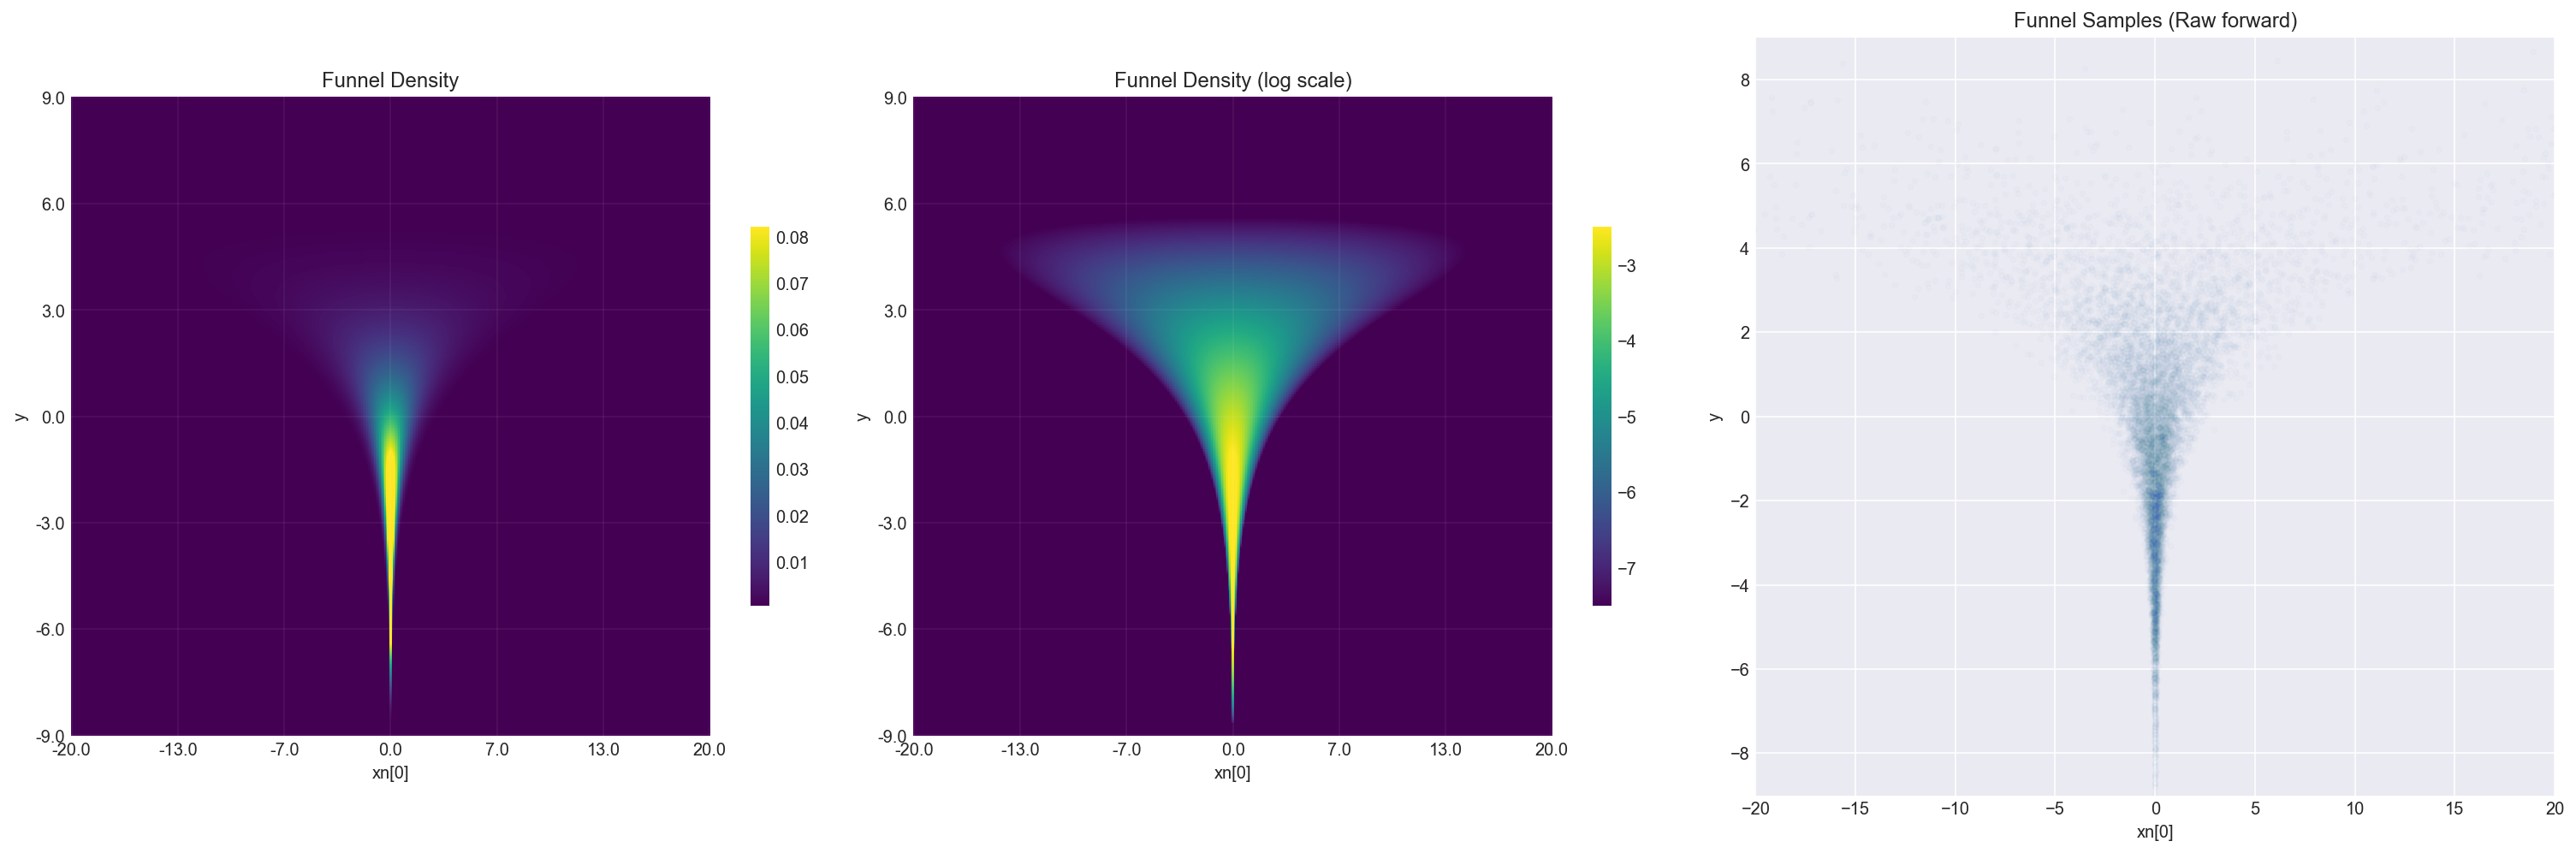

In [6]:
ib = 0
_, ax = plt.subplots(1, 3, figsize=(21, 7))
show_logp2d(logp_2d, ax[0], np.exp)
ax[0].set_title('Funnel Density')
show_logp2d(logp_2d, ax[1])
ax[1].set_title('Funnel Density (log scale)')
show_sample2d(xnr, yr, ib, ax[2])
ax[2].set_title('Funnel Samples (Raw forward)')
plt.tight_layout();

In [53]:
with pm.Model() as m_raw:
    y_ = pm.Normal('y', mu=0., sd=3.)
    x_ = pm.Normal('x', mu=0., sd=pm.math.exp(y_/2), shape=nd)
    trace = pm.sample(nsample, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, y]
100%|██████████| 12000/12000 [00:25<00:00, 477.28it/s] 
There were 523 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39862603600471436, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


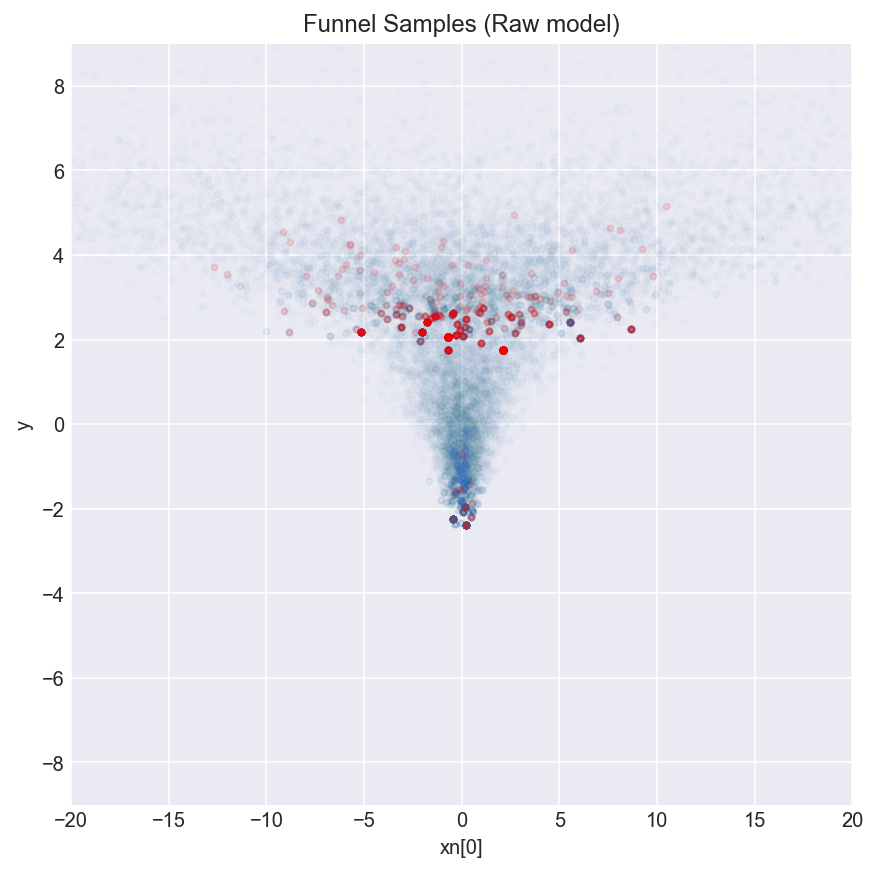

In [54]:
divg = trace.get_sampler_stats('diverging')

_, ax = plt.subplots(1, 1, figsize=(7, 7))
show_sample2d(trace['x'].T, trace['y'], ib, ax)
ax.scatter(trace['x'][divg, ib], trace['y'][divg], marker='.', color='r', alpha=.1)
ax.set_title('Funnel Samples (Raw model)');

### Reparameterization trick

A general transform from a centered to a non-centered parameterization was proposed by Papaspiliopoulos et al (2007):  

$$
y_{raw} \sim \text{Normal(0, 1)}\\
x_{raw} \sim \text{Normal(0, 1)}\\
\text{implies}\\
y = y_{raw} * 3 \sim \text{Normal(0, 1)}\\
x = x_{raw} * e^{y/2} \sim \text{Normal}(0,e^{y/2})
$$

It is also called a affine transformation (e.g., in tensorflow probability). This reparameterization is helpful when there is not much data, because it separates the hierarchical parameters and lower-level parameters in the prior. 

A Bayesian posterior is technically a probability _measure_, which is a parameterization-invariant, abstract mathematical object.  

Modern PPL, on the other hand, defines a probability _density_, which is a non-unique, parameterization-dependent function in $\mathbb{R}^N \rightarrow \mathbb{R}{+}$.  In practice, this means a given model can be represented different ways, and different representations have different computational performances.


In [9]:
with pm.Model() as m_tran:
    y_raw = pm.Normal('y_raw', mu=0., sd=1.)
    x_raw = pm.Normal('x_raw', mu=0., sd=1., shape=nd)
    y_ = pm.Deterministic('y', 3. * y_raw)
    x_ = pm.Deterministic('x', pm.math.exp(y_/2) * x_raw)
    trace2 = pm.sample(nsample, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_raw, y_raw]
100%|██████████| 12000/12000 [00:21<00:00, 571.06it/s]


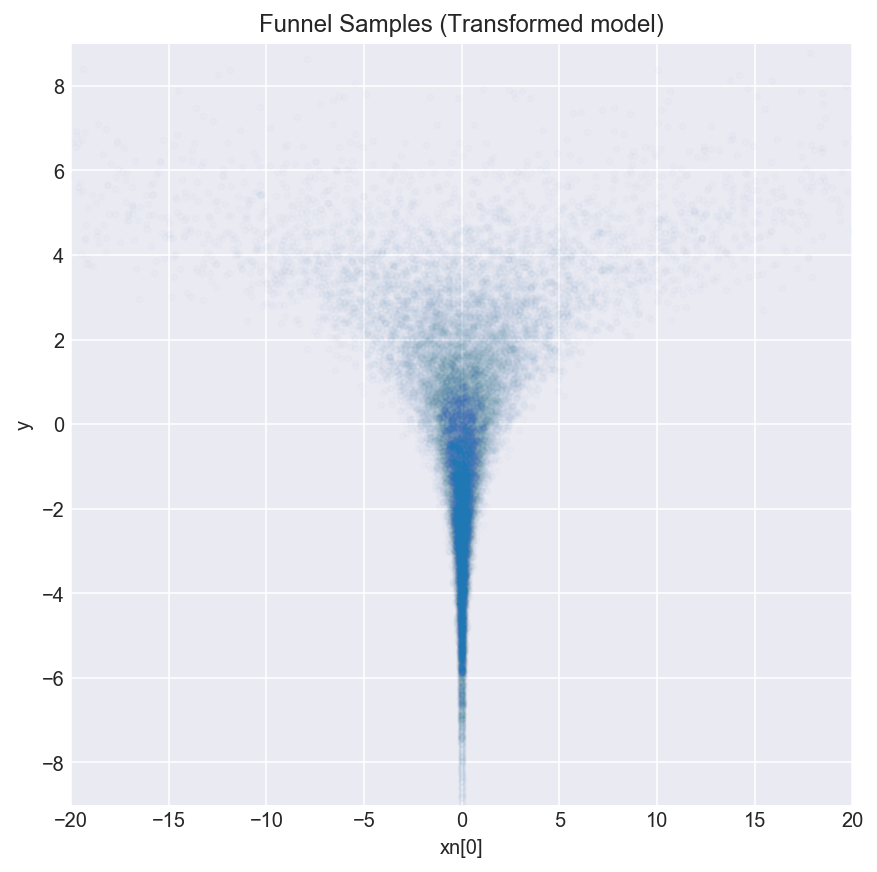

In [10]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))
show_sample2d(trace2['x'].T, trace2['y'], ib, ax)
ax.set_title('Funnel Samples (Transformed model)');

In [11]:
yr2 = st.norm.rvs(loc=0., scale=1., size=nsample) * 3.
xnr2 = st.norm.rvs(loc=0., scale=1., size=(nd, nsample)) * np.exp(yr2/2)

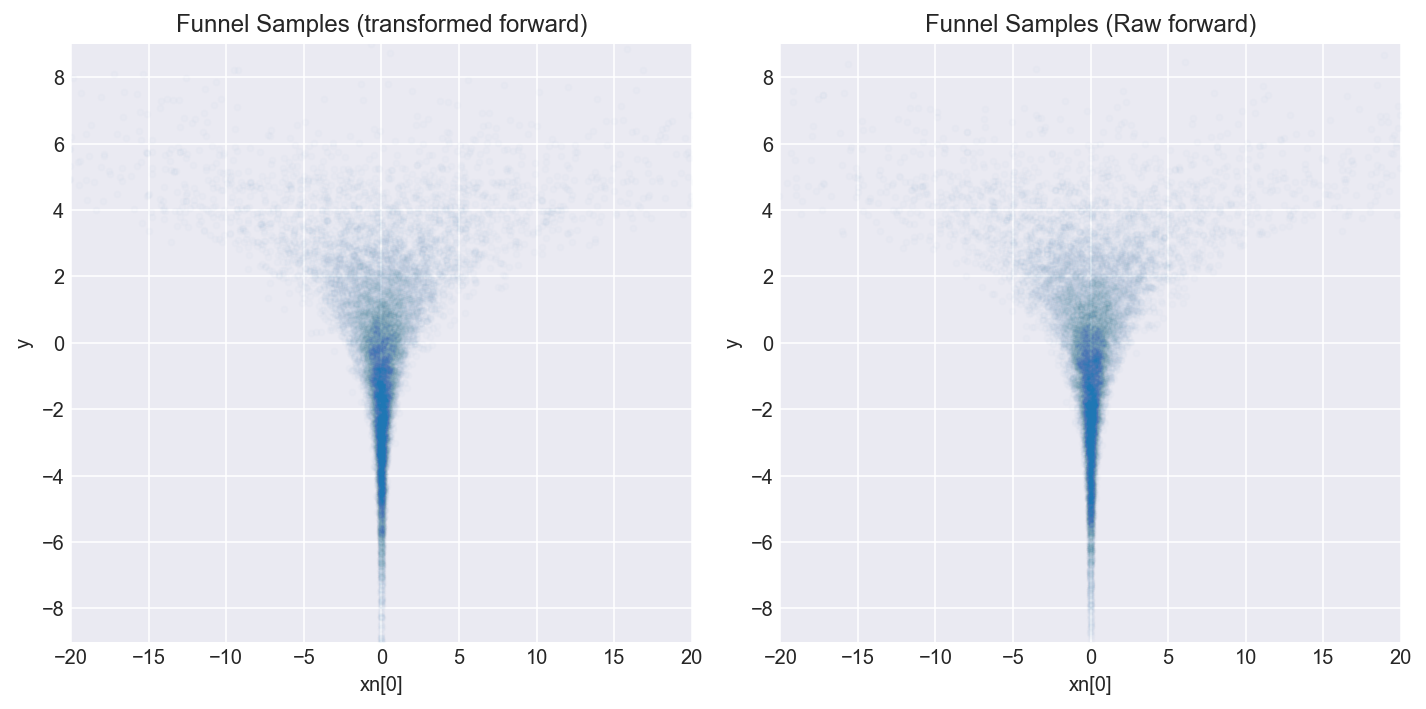

In [12]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
show_sample2d(xnr2, yr2, ib, ax[0])
ax[0].set_title('Funnel Samples (transformed forward)')
show_sample2d(xnr, yr, ib, ax[1])
ax[1].set_title('Funnel Samples (Raw forward)')
plt.tight_layout();

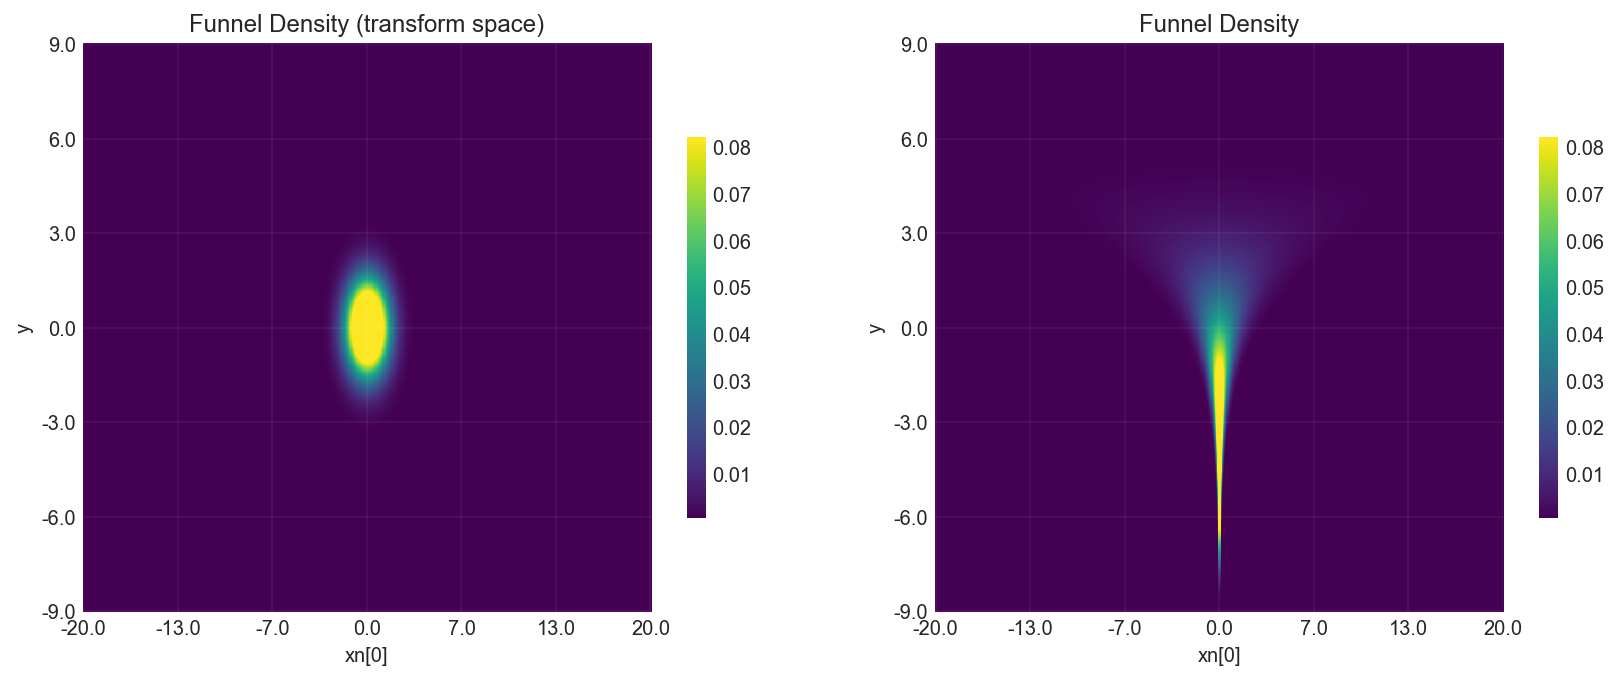

In [13]:
_, ax = plt.subplots(1, 2, figsize=(14, 7))
logp_2d_t = st.norm.logpdf(yv, loc=0., scale=1.) +\
    st.norm.logpdf(xv, loc=0., scale=1.)
show_logp2d(logp_2d_t, ax[0], np.exp)
ax[0].set_title('Funnel Density (transform space)')
show_logp2d(logp_2d, ax[1], np.exp)
ax[1].set_title('Funnel Density');

In [14]:
# nres2 = 50
# xval2 = np.linspace(-20, 20, nres2)
# yval2 = np.linspace(-9, 9, nres2)
# xv2, yv2 = np.meshgrid(xval2, yval2)
# V = yv2 * 3.
# U = xv2 * np.exp(V/2.)
# M = st.norm.logpdf(yv2, loc=0., scale=1.) +\
#     st.norm.logpdf(xv2, loc=0., scale=1.)
# Q = ax[2].quiver(xv2, yv2, U, V, M, units='x',  width=0.05,
#                scale=1/.25, cmap='viridis');

In [15]:
def plot_grid(ax, gridx, gridy, **kwargs):
    for i in range(gridx.shape[0]):
        ax.plot(gridx[i, :], gridy[i, :], **kwargs)
    for i in range(gridx.shape[1]):
        ax.plot(gridx[:, i], gridy[:, i], **kwargs)
    ax.grid('off')


def f(x, y): return (np.exp(y*3/2.) * x, y*3.)

In [16]:
nres2 = 100
xval2 = np.linspace(-20, 20, nres2)
yval2 = np.linspace(-9, 9, nres2)
xv2, yv2 = np.meshgrid(xval2, yval2)

distx, disty = f(xv2, yv2)

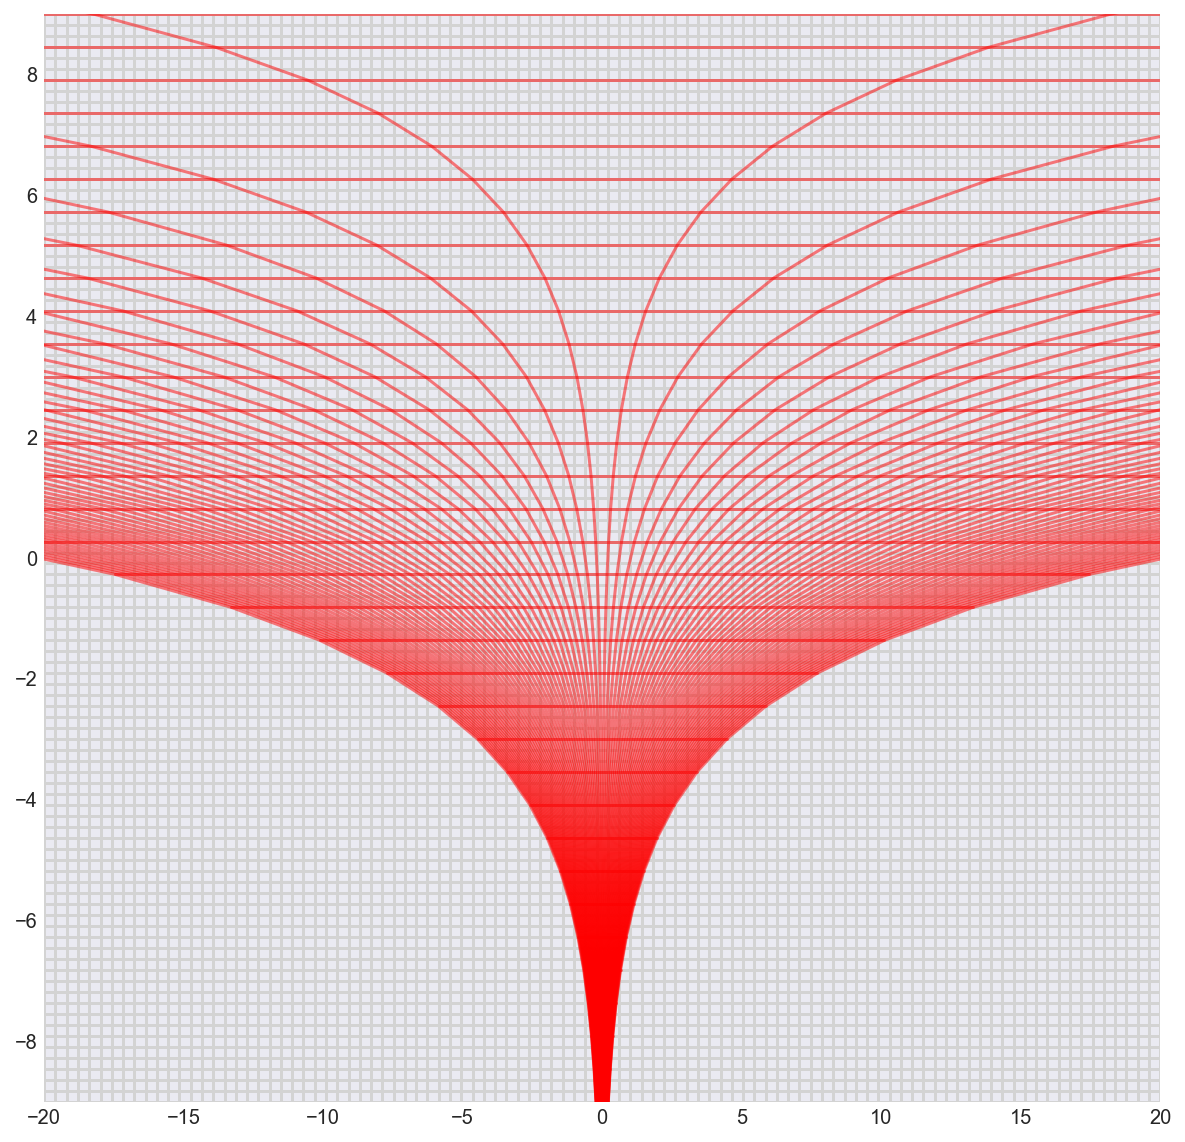

In [17]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_grid(ax, xv2, yv2, color="lightgrey")
plot_grid(ax, distx, disty, color="r", alpha=.5)
ax.set_xlim(-20, 20)
ax.set_ylim(-9, 9);

In [18]:
pt = m_raw.test_point
pt

{'x': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'y': array(0.)}

In [19]:
m_tran.test_point

{'x_raw': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'y_raw': array(0.)}

In [20]:
def forward_point(point):
    pt = point
    pt['y'] = point['y_raw']*3.
    pt['x'] = point['x_raw']*np.exp(pt['y']/2)
    return pt

def inverse_point(point):
    pt = point
    pt['y_raw'] = point['y']/3.
    pt['x_raw'] = point['x']/np.exp(point['y']/2)
    return pt

In [21]:
logp_ref = lambda x, y: st.norm.logpdf(y, loc=0., scale=3.) +\
    st.norm.logpdf(x, loc=0., scale=np.exp(y/2)).sum()
print('The sum(logp) of the test point is {}'.format(logp_ref(pt['x'], pt['y'])))
print('Compute sum(logp) using the model: {}'.format(m_raw.logp(pt)))

The sum(logp) of the test point is -10.287997620714837
Compute sum(logp) using the model: -10.287997620714835


In [22]:
print('Compute sum(logp) using the transformed model: {}'.format(m_tran.logp(inverse_point(pt))))

Compute sum(logp) using the transformed model: -9.189385332046724


In [23]:
pt['y'] = -3.
print('The sum(logp) of the test point is {}'
      .format(logp_ref(pt['x'], pt['y'])))
print('Compute sum(logp) using the model: {}'
      .format(m_raw.logp(pt)))
print('Compute sum(logp) using the transformed model: {}'
      .format(m_tran.logp(inverse_point(pt))))

The sum(logp) of the test point is 2.712002379285164
Compute sum(logp) using the model: 2.7120023792851637
Compute sum(logp) using the transformed model: -9.689385332046724


# Measure-preserving transformation

## Univariate Changes of Variables

Suppose $X$ is one dimensional and $f: \mbox{supp}(X) \rightarrow
\mathbb{R}$ is a one-to-one, monotonic function with a differentiable
inverse $f^{-1}$.  Then the density of $Y$ is given by
$$
p_Y(y) = p_X(f^{-1}(y))
         \,
         \left| \, \frac{d}{dy} f^{-1}(y)\, \right|.
$$
The absolute derivative of the inverse transform measures how the
scale of the transformed variable changes with respect to the
underlying variable.

## Multivariate Changes of Variables

The multivariate generalization of an absolute derivative is a Jacobian, or more fully the absolute value of the determinant of the Jacobian matrix of the transform. The Jacobian matrix measures the change of each output variable relative to every input variable and the absolute determinant uses that to determine the differential change in volume at a given point in the parameter space.

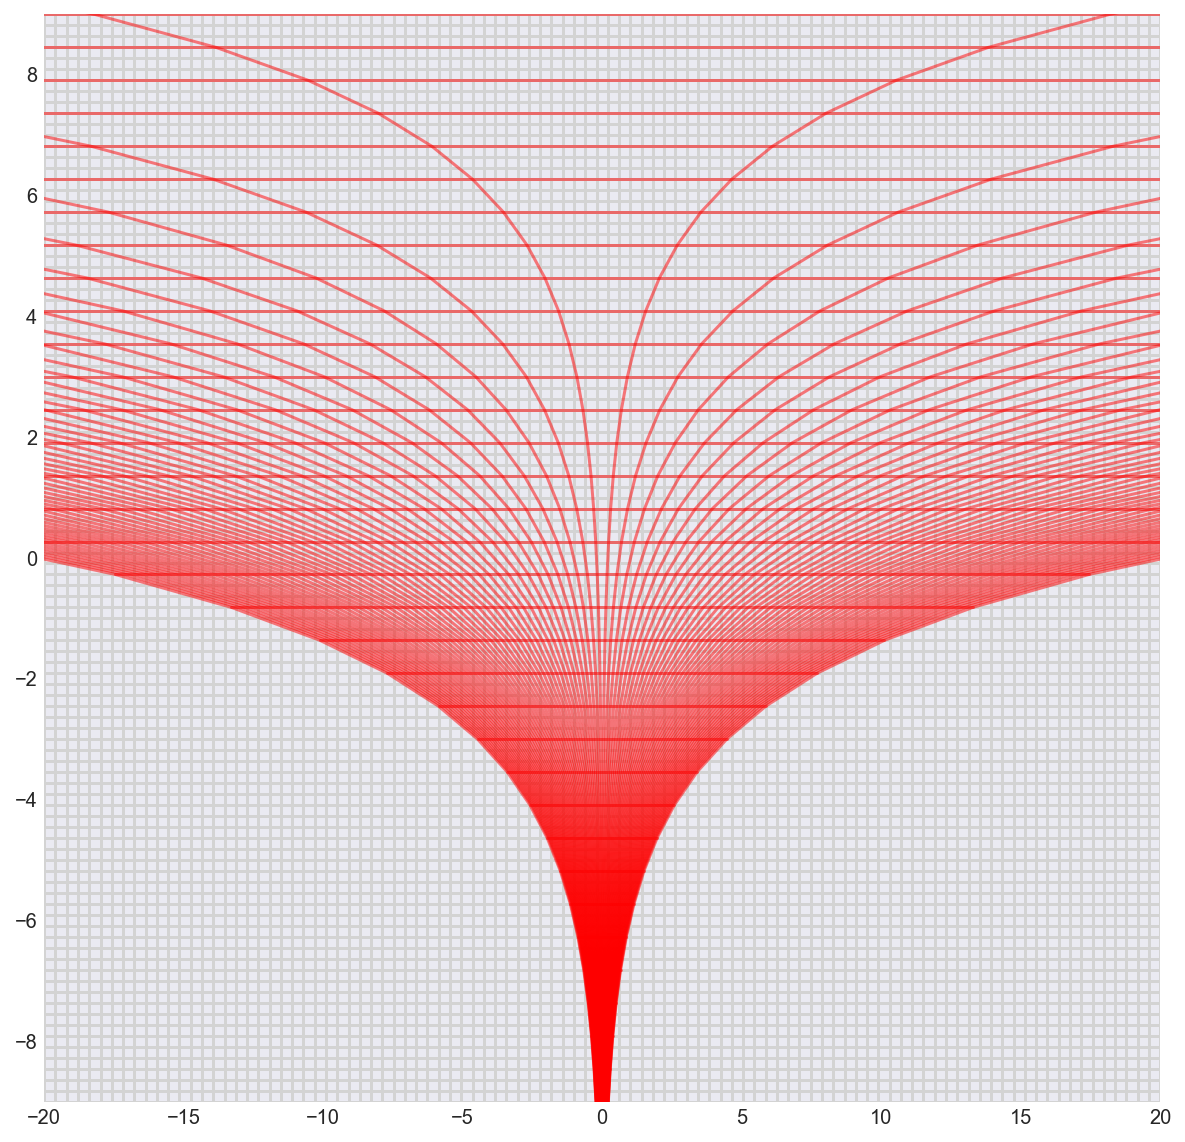

In [24]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_grid(ax, xv2, yv2, color="lightgrey")
plot_grid(ax, distx, disty, color="r", alpha=.5)
ax.set_xlim(-20, 20)
ax.set_ylim(-9, 9);

Suppose $X$ is a $K$-dimensional random variable with probability
density function $p_X(x)$.  A new random variable $Y = f(X)$ may be
defined by transforming $X$ with a suitably well-behaved function $f$.
It suffices for what follows to note that if $f$ is one-to-one
and its inverse $f^{-1}$ has a well-defined Jacobian, then the
density of $Y$ is  

$$
p_Y(y) = p_X(f^{-1}(y)) \, \left| \, \det \, J_{f^{-1}}(y) \, \right|,
$$  

where $\det{}$ is the matrix determinant operation and $J_{f^{-1}}(y)$
is the Jacobian matrix of $f^{-1}$ evaluated at $y$. 

Taking $x =
f^{-1}(y)$, the Jacobian matrix is defined by
$$
J_{f^{-1}}(y) =
\left[
\begin{array}{ccc}\displaystyle
\frac{\partial x_1}{\partial y_1}
& \cdots
& \displaystyle \frac{\partial x_1}{\partial y_{K}}
\\[6pt]
\vdots & \vdots & \vdots
\\
\displaystyle\frac{\partial x_{K}}{\partial y_1}
& \cdots
& \displaystyle\frac{\partial x_{K}}{\partial y_{K}}
\end{array}
\right].
$$

In our case, we have:  
$$
f^{-1}(x, y) = 
\left[
\begin{array}{cc}\displaystyle
\frac{x}{e^{y/2}}
& \displaystyle \frac{y}{3}
\end{array}
\right].
$$  
which gives
$$
J_{f^{-1}}(y) =
\left[
\begin{array}{cc}\displaystyle
\frac{\partial x_1}{\partial y_1}
& \displaystyle \frac{\partial x_1}{\partial y_{K}}
\\
\displaystyle\frac{\partial x_{K}}{\partial y_1}
& \displaystyle\frac{\partial x_{K}}{\partial y_{K}}
\end{array}
\right] 
=
\left[
\begin{array}{cc}\displaystyle
e^{-y/2}
& \displaystyle -\frac{1}{2}x e^{-y/2}
\\
\displaystyle 0
& \displaystyle\frac{1}{3}
\end{array}
\right]
$$
and 
$$ 
\left| \, \det \, J_{f^{-1}}(y) \, \right| = \left| \, \frac{e^{-y/2}}{3} \, \right|.
$$

In [25]:
with pm.Model() as m_tran_withjac:
    y_raw = pm.Normal('y_raw', mu=0., sd=1.)
    x_raw = pm.Normal('x_raw', mu=0., sd=1., shape=nd)
    y_ = pm.Deterministic('y', 3. * y_raw)
    x_ = pm.Deterministic('x', pm.math.exp(y_/2) * x_raw)
    
    pm.Potential('pot', np.log(1/3)+pm.math.log(pm.math.abs_(pm.math.exp(-y_/2)))*nd)

In [26]:
print('Compute sum(logp) using the transformed model with correct jacobian_det: {}'
      .format(m_tran_withjac.logp(inverse_point(pt))))

Compute sum(logp) using the transformed model with correct jacobian_det: 2.712002379285167


In [27]:
pt['y'] = st.norm.rvs(loc=0., scale=3.)
pt['x'] = st.norm.rvs(loc=0., scale=np.exp(pt['y']/2), size=(nd))
print('The sum(logp) of the test point is {}'
      .format(logp_ref(pt['x'], pt['y'])))
print('Compute sum(logp) using the model: {}'
      .format(m_raw.logp(pt)))
print('Compute sum(logp) using the transformed model 2: {}'
      .format(m_tran_withjac.logp(inverse_point(pt))))

The sum(logp) of the test point is -21.86747237370433
Compute sum(logp) using the model: -21.867472373704327
Compute sum(logp) using the transformed model 2: -21.867472373704324


Additional validation of jacobian determinant

In [28]:
logp_ref1 = lambda x, y: st.norm.logpdf(y, loc=0., scale=3.) +\
    st.norm.logpdf(x, loc=0., scale=np.exp(y/2))

logp_ref2 = lambda x, y: st.norm.logpdf(y/3., loc=0., scale=1.) +\
    st.norm.logpdf(x/np.exp(y/2), loc=0., scale=1.) +\
    np.log(1/3)+\
    np.log(np.abs(np.exp(-y/2)))

xtest = st.norm.rvs(loc=0., scale=1.)
ytest = st.norm.rvs(loc=0., scale=1.)

print('The sum(logp) of the test point is {}'
      .format(logp_ref1(xtest, ytest)))
print('The sum(logp) of the test point is {}'
      .format(logp_ref2(xtest, ytest)))

The sum(logp) of the test point is -5.119593158789675
The sum(logp) of the test point is -5.119593158789675


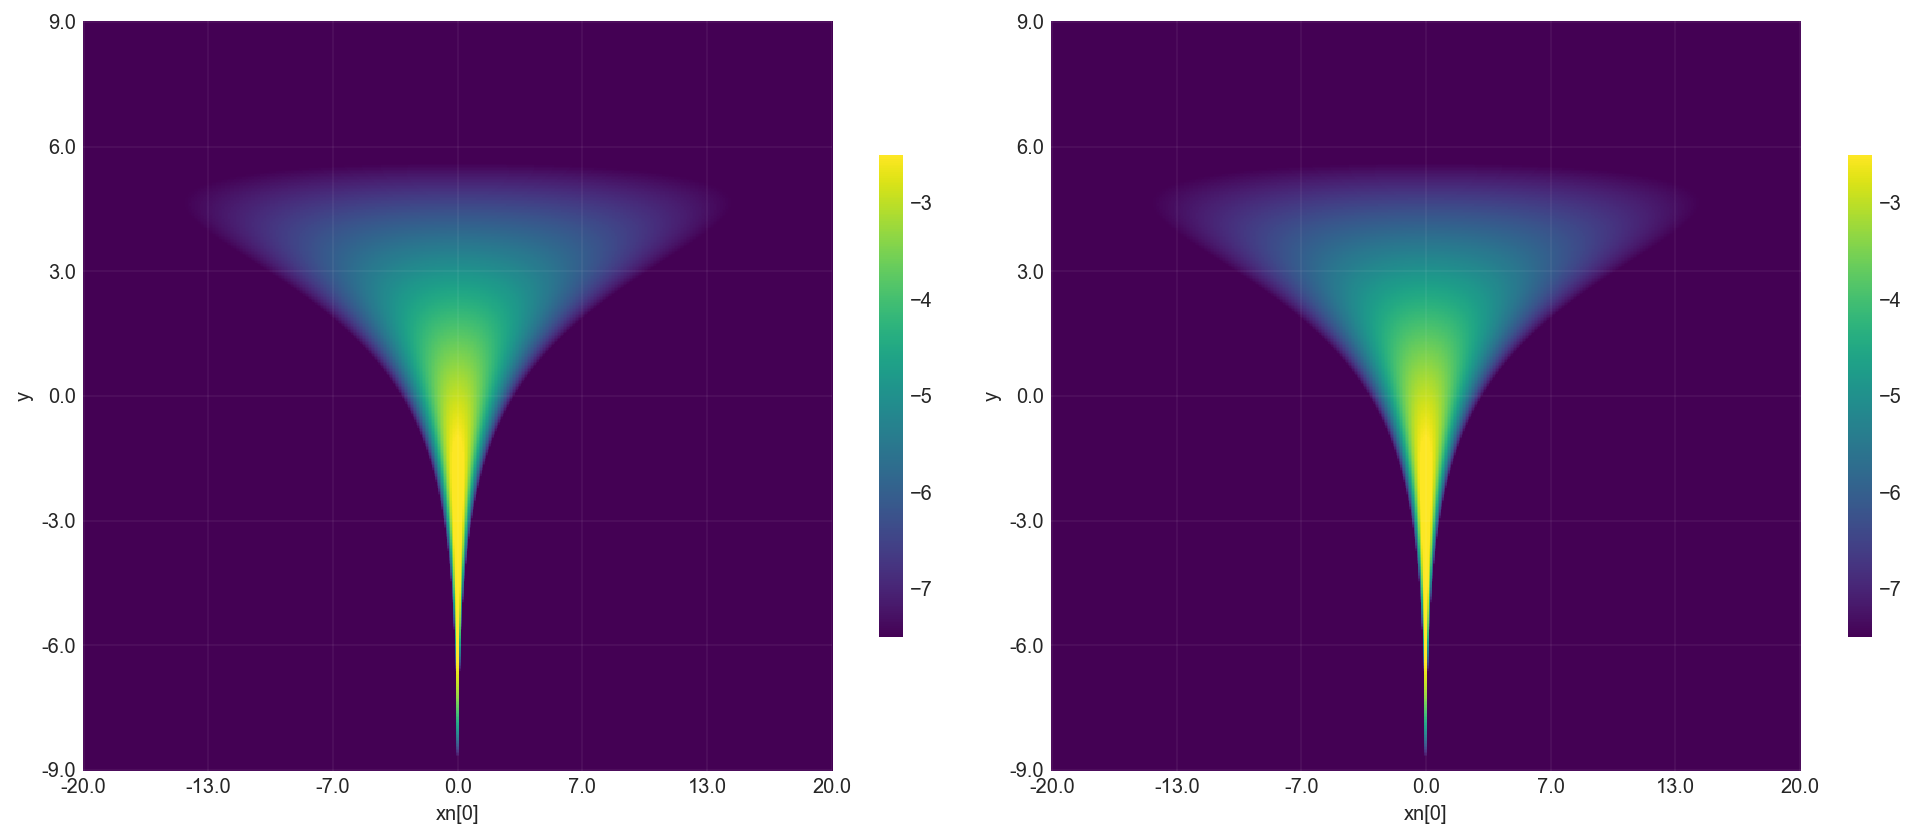

In [29]:
logp_2d = logp_ref1(xv, yv)
logp_2d2 = logp_ref2(xv, yv)
_, ax = plt.subplots(1, 2, figsize=(14, 7))
show_logp2d(logp_2d, ax[0])
show_logp2d(logp_2d2, ax[1])
plt.tight_layout()

In [30]:
y_raw = np.random.randn()
y = 3.*y_raw

np.testing.assert_almost_equal(pm.Normal.dist(mu=0., sd=3.).logp(y).eval(),
                               pm.Normal.dist(mu=0., sd=1.).logp(y_raw).eval() + np.log(1/3))

x_raw = np.random.randn(nd)
x = np.exp(y/2)*x_raw

np.testing.assert_almost_equal(
    pm.Normal.dist(mu=0., sd=np.exp(y/2), shape=nd).logp(x).eval(),
    pm.Normal.dist(mu=0., sd=1., shape=nd).logp(x_raw).eval() +\
                 np.log(np.abs(np.exp(-y/2))))

However, the jacobian determinant is in fact not correct

In [31]:
with m_tran_withjac:
    trace3 = pm.sample(nsample, tune=2000, init='adapt_diag')

divg = trace3.get_sampler_stats('diverging')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_raw, y_raw]
100%|██████████| 12000/12000 [00:23<00:00, 504.35it/s]


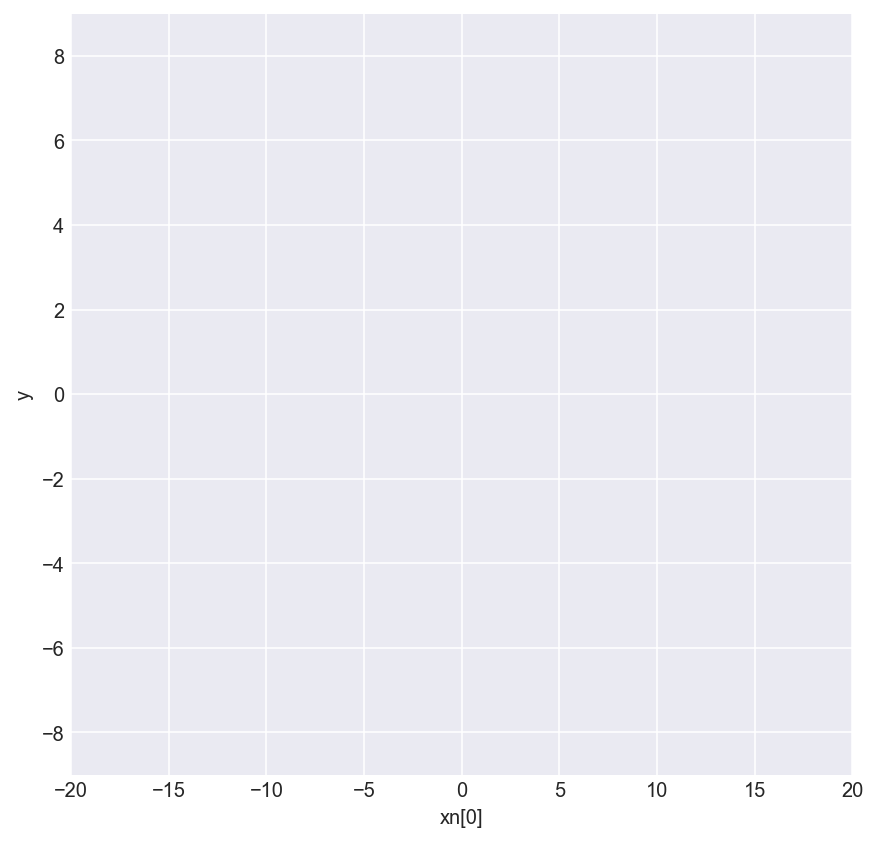

In [32]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))
show_sample2d(trace3['x'].T, trace3['y'], ib, ax)
ax.scatter(trace3['x'][divg, ib], trace3['y'][divg], marker='.', color='r', alpha=.1);

In [33]:
func1 = m_tran_withjac.logp_dlogp_function()

In [34]:
func1.set_extra_values(pt)
func1(func1.dict_to_array(inverse_point(pt)))

(array(-21.86747237),
 array([-14.08431211,   0.95370654,   0.13512088,  -1.23699399,
         -0.92475836,   1.71875779,   0.23092269,   0.81470072,
          0.12380003,   0.2035645 ]))

In [35]:
func0 = m_raw.logp_dlogp_function()

In [36]:
func0.set_extra_values(pt)
func0(func0.dict_to_array(pt))

(array(-21.86747237),
 array([-1.17421979,  0.39698077,  0.05624413, -0.5148993 , -0.38493108,
         0.7154337 ,  0.09612167,  0.33911954,  0.05153182,  0.08473381]))

Different gradient!

In [37]:
from theano.gradient import disconnected_grad as stop_grad
import theano.tensor as tt
import theano

In [38]:
with pm.Model() as m_raw2:
    y = pm.Flat('y')
    x = pm.Flat('x', shape=nd)

    pm.Potential('ypot', pm.Normal.dist(mu=0., sd=3.).logp(y))
    pm.Potential('xpot', pm.Normal.dist(
        mu=0., sd=pm.math.exp(y / 2), shape=nd).logp(x))

In [39]:
with pm.Model() as m_tran_withjac1:
    y = pm.Flat('y', shape=1)
    x = pm.Flat('x', shape=nd)

    y_inv = y / 3.
    x_inv = x / pm.math.exp(y / 2)

    f_inv = tt.concatenate([x_inv, y_inv], axis=0)
    J, updates = theano.scan(lambda i, f_inv, y1, y2: 
                             tt.concatenate(tt.grad(f_inv[i].sum(), [y1, y2]), axis=0),
                             sequences=tt.arange(f_inv.shape[0]),
                             non_sequences=[f_inv, x, y])

    pm.Potential('ypot', pm.Normal.dist(mu=0., sd=1.).logp(y_inv))
    pm.Potential('xpot', pm.Normal.dist(mu=0., sd=1., shape=nd).logp(x_inv))
    pm.Potential('pot', tt.log(tt.abs_(tt.nlinalg.det(J))))

In [40]:
pt['y'] = st.norm.rvs(loc=0., scale=3., size=(1))
pt['x'] = st.norm.rvs(loc=0., scale=np.exp(pt['y']/2), size=(nd))

In [41]:
func0 = m_raw2.logp_dlogp_function()

In [42]:
func0.set_extra_values(pt)
func0(func0.dict_to_array(pt))

(array(-9.14372779),
 array([-0.59845072, -2.40193878,  0.09054529,  1.16072596,  2.42458577,
         0.76085353, -1.47105603, -2.17535499, -1.42752945, -0.6264619 ]))

In [43]:
func1 = m_tran_withjac1.logp_dlogp_function()

In [44]:
func1.set_extra_values(pt)
func1(func1.dict_to_array(pt))

(array(-9.14372779),
 array([-0.59845072, -2.40193878,  0.09054529,  1.16072596,  2.42458577,
         0.76085353, -1.47105603, -2.17535499, -1.42752945, -0.6264619 ]))

In [45]:
from pymc3.distributions.transforms import Transform

class Nealfun(Transform):
    name = "Neal_funnel"
    def backward(self, y):
        x = tt.zeros(y.shape)
        x = tt.inc_subtensor(x[0], y[0] / 3.)
        x = tt.inc_subtensor(x[1:], y[1:] / tt.exp(y[0] / 2))
        return x
    def forward(self, x):
        y = tt.zeros(x.shape)
        y = tt.inc_subtensor(y[0], x[0] * 3.)
        y = tt.inc_subtensor(y[1:], tt.exp(x[0] * 3. / 2) * x[1:])
        return y
    def jacobian_det(self, x):
        f_inv = self.backward(x)
        J, updates = theano.scan(lambda i, f_inv, x: tt.grad(f_inv[i], x),
                                 sequences=tt.arange(f_inv.shape[0]),
                                 non_sequences=[f_inv, x])
        return tt.log(tt.abs_(tt.nlinalg.det(J)))

In [46]:
def tran_point(pt):
    point = dict()
    point['raw_Neal_funnel__'] = np.concatenate([pt['y'], pt['x']], axis=0)
    return point

In [47]:
with pm.Model() as m_tran_withjac2:
    raw = pm.Normal('raw', mu=0., sd=1., shape=(1+nd),
                    transform=Nealfun(), 
                    testval=np.zeros(1+nd))

func2 = m_tran_withjac2.logp_dlogp_function()
func2.set_extra_values(pt)
func2(func2.dict_to_array(tran_point(pt)))

(array(-9.14372779),
 array([-0.59845072, -2.40193878,  0.09054529,  1.16072596,  2.42458577,
         0.76085353, -1.47105603, -2.17535499, -1.42752945, -0.6264619 ]))

In [48]:
pt = dict()
pt['y'] = st.norm.rvs(loc=0., scale=3., size=(1))
pt['x'] = st.norm.rvs(loc=0., scale=np.exp(pt['y']/2), size=(nd))

func0.set_extra_values(pt)
print(func0(func0.dict_to_array(pt)))
func1.set_extra_values(pt)
print(func1(func1.dict_to_array(pt)))
func2.set_extra_values(pt)
print(func2(func2.dict_to_array(tran_point(pt))))

(array(-20.57943224), array([ 2.29955314, -0.20169182,  0.30398011, -1.33662851, -0.84661285,
       -1.47992288, -0.00442497,  0.93832913,  0.88825638, -0.05739965]))
(array(-20.57943224), array([ 2.29955314, -0.20169182,  0.30398011, -1.33662851, -0.84661285,
       -1.47992288, -0.00442497,  0.93832913,  0.88825638, -0.05739965]))
(array(-20.57943224), array([ 2.29955314, -0.20169182,  0.30398011, -1.33662851, -0.84661285,
       -1.47992288, -0.00442497,  0.93832913,  0.88825638, -0.05739965]))


In [ ]:
with m_tran_withjac2:
    pm.Deterministic('y', m_tran_withjac2.free_RVs[0][0])
    pm.Deterministic('x', m_tran_withjac2.free_RVs[0][1:])

    trace4 = pm.sample(nsample, tune=2000)

divg = trace4.get_sampler_stats('diverging')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [raw_Neal_funnel__]
 41%|████      | 4900/12000 [01:54<02:17, 51.52it/s]  

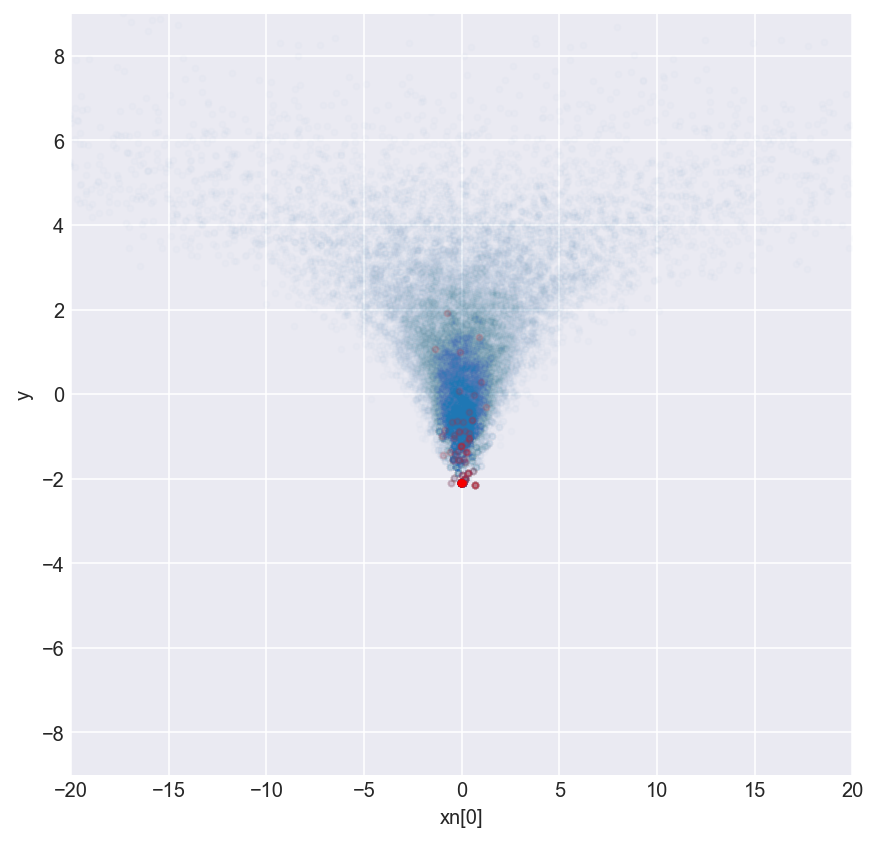

In [52]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))
show_sample2d(trace4['x'].T, trace4['y'], ib, ax)
ax.scatter(trace4['x'][divg, ib], trace4['y'][divg], marker='.', color='r', alpha=.1);